## Laboratorio 06 - Simulación de un modelo SIR

### Simulación vía partículas 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython.display import HTML
import os

#### Definición de parámetros

In [13]:
L = 100.0                    # Tamaño del cuadrado [0,L] x [0,L]
N_total = 300                # Población total de partículas
I_0 = 5                      # Número inicial de infectados
V_max = 2.0                  # Velocidad máxima de las partículas
r = 3.0                      # Radio de contagio
beta = 0.3                   # Tasa de infección (probabilidad por contacto)
gamma = 0.05                 # Tasa de recuperación por unidad de tiempo
dt = 0.1                     # Delta de tiempo
T_max = 200.0                # Tiempo máximo de simulación
fps = 30                     # Frames por segundo para la animación


#### Clase partícula

In [14]:
class Particle:
    """Representa una partícula en el sistema SIR"""
    
    def __init__(self, x, y, vx, vy, state=0):
        self.x = x          # Posición x
        self.y = y          # Posición y
        self.vx = vx        # Velocidad en x
        self.vy = vy        # Velocidad en y
        self.state = state  # 0: susceptible, 1: infectado, 2: recuperado
        self.time_infected = 0.0  # Tiempo que lleva infectado
    
    def move(self, dt, L):
        """Mueve la partícula y maneja rebotes en las paredes"""
        # Actualizar posición
        self.x += self.vx * dt
        self.y += self.vy * dt
        
        # Rebote en paredes (colisión elástica)
        if self.x <= 0 or self.x >= L:
            self.vx = -self.vx
            self.x = np.clip(self.x, 0, L)
        
        if self.y <= 0 or self.y >= L:
            self.vy = -self.vy
            self.y = np.clip(self.y, 0, L)
    
    def distance_to(self, other):
        """Calcula la distancia a otra partícula"""
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

#### Inicialización del sistema

In [15]:
def initialize_particles(N_total, I_0, L, V_max):
    """Inicializa N_total partículas con I_0 infectados"""
    particles = []
    
    for i in range(N_total):
        # Posición aleatoria
        x = np.random.uniform(0, L)
        y = np.random.uniform(0, L)
        
        # Velocidad aleatoria con magnitud constante V_max
        angle = np.random.uniform(0, 2 * np.pi)
        vx = V_max * np.cos(angle)
        vy = V_max * np.sin(angle)
        
        # Estado: primeros I_0 son infectados, resto susceptibles
        state = 1 if i < I_0 else 0
        
        particles.append(Particle(x, y, vx, vy, state))
    
    return particles

#### Lógica de actualización del sistema

In [16]:
def update_system(particles, dt, r, beta, gamma, N_total):
    """Actualiza el estado de todas las partículas"""
    
    # Primero, mover todas las partículas
    for p in particles:
        p.move(dt, L)
    
    # Detectar colisiones y posibles contagios
    for i, p1 in enumerate(particles):
        if p1.state == 1:  # Si está infectado
            # Actualizar tiempo de infección
            p1.time_infected += dt
            
            # Verificar recuperación (proceso estocástico)
            if np.random.random() < gamma * dt:
                p1.state = 2  # Recuperado
            
            # Verificar contagios
            for j, p2 in enumerate(particles):
                if i != j and p2.state == 0:  # Si p2 es susceptible
                    dist = p1.distance_to(p2)
                    if dist < r:  # Dentro del radio de contagio
                        # Contagio con probabilidad beta (ajustada por dt)
                        if np.random.random() < beta * dt:
                            p2.state = 1  # Se infecta
                            p2.time_infected = 0.0

def count_states(particles):
    """Cuenta el número de partículas en cada estado"""
    S = sum(1 for p in particles if p.state == 0)
    I = sum(1 for p in particles if p.state == 1)
    R = sum(1 for p in particles if p.state == 2)
    return S, I, R


#### Simulación principal

In [17]:
def run_simulation(particles, T_max, dt, r, beta, gamma, N_total):
    """Ejecuta la simulación y guarda los resultados"""
    
    time_points = []
    S_history = []
    I_history = []
    R_history = []
    
    # Guardar snapshots de posiciones para animación
    snapshots = []
    
    t = 0.0
    step = 0
    # Guardar frames según fps (mínimo 1 para evitar división por cero)
    save_interval = max(1, int(1.0 / (dt * fps)))
    
    while t < T_max:
        # Actualizar sistema
        update_system(particles, dt, r, beta, gamma, N_total)
        
        # Contar estados
        S, I, R = count_states(particles)
        
        # Guardar datos
        time_points.append(t)
        S_history.append(S)
        I_history.append(I)
        R_history.append(R)
        
        # Guardar snapshot para animación
        if step % save_interval == 0:
            snapshot = [(p.x, p.y, p.state) for p in particles]
            snapshots.append((t, snapshot, S, I, R))
        
        # Si no hay más infectados, terminar
        if I == 0 and t > 10:
            break
        
        t += dt
        step += 1
    
    return time_points, S_history, I_history, R_history, snapshots

# Inicializar partículas
print("Inicializando partículas...")
particles = initialize_particles(N_total, I_0, L, V_max)

# Ejecutar simulación
print("Ejecutando simulación...")
time_points, S_history, I_history, R_history, snapshots = run_simulation(
    particles, T_max, dt, r, beta, gamma, N_total
)

print(f"Simulación completada. Total de pasos: {len(time_points)}")
print(f"Frames guardados para animación: {len(snapshots)}")

Inicializando partículas...
Ejecutando simulación...
Simulación completada. Total de pasos: 1756
Frames guardados para animación: 1756


#### Visualización 

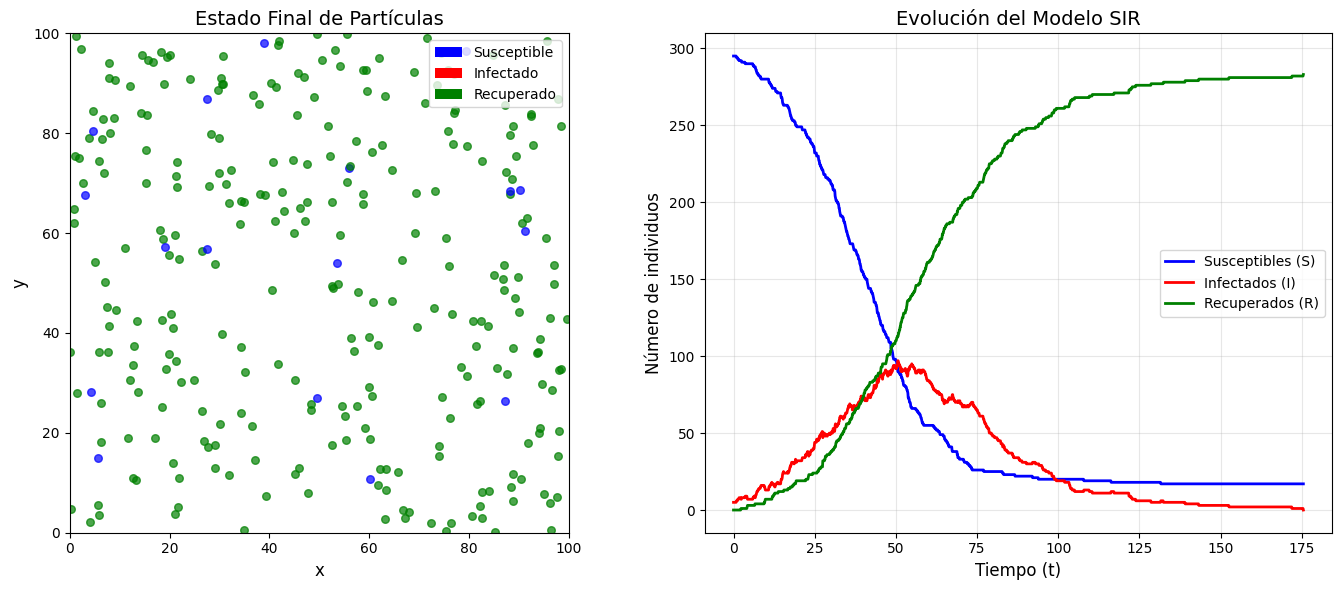

Visualización estática guardada como 'sir_simulation_final.png'


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica de curvas S(t), I(t), R(t)
ax2.plot(time_points, S_history, 'b-', label='Susceptibles (S)', linewidth=2)
ax2.plot(time_points, I_history, 'r-', label='Infectados (I)', linewidth=2)
ax2.plot(time_points, R_history, 'g-', label='Recuperados (R)', linewidth=2)
ax2.set_xlabel('Tiempo (t)', fontsize=12)
ax2.set_ylabel('Número de individuos', fontsize=12)
ax2.set_title('Evolución del Modelo SIR', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Estado final de las partículas
final_snapshot = snapshots[-1][1]
for x, y, state in final_snapshot:
    color = 'blue' if state == 0 else ('red' if state == 1 else 'green')
    ax1.scatter(x, y, c=color, s=30, alpha=0.7)

ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax1.set_aspect('equal')
ax1.set_title('Estado Final de Partículas', fontsize=14)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Susceptible'),
    Patch(facecolor='red', label='Infectado'),
    Patch(facecolor='green', label='Recuperado')
]
ax1.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('sir_simulation_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualización estática guardada como 'sir_simulation_final.png'")


#### Animación

In [ ]:
print("\nCreando animación...")

fig_anim, (ax_particles, ax_curves) = plt.subplots(1, 2, figsize=(14, 6))

# Configurar subplot de partículas
ax_particles.set_xlim(0, L)
ax_particles.set_ylim(0, L)
ax_particles.set_aspect('equal')
ax_particles.set_xlabel('x', fontsize=12)
ax_particles.set_ylabel('y', fontsize=12)

# Configurar subplot de curvas
ax_curves.set_xlim(0, max(time_points))
ax_curves.set_ylim(0, N_total)
ax_curves.set_xlabel('Tiempo (t)', fontsize=12)
ax_curves.set_ylabel('Número de individuos', fontsize=12)
ax_curves.grid(True, alpha=0.3)

# Inicializar elementos de la animación
scatter = ax_particles.scatter([], [], s=30, alpha=0.7)
time_text = ax_particles.text(0.02, 0.98, '', transform=ax_particles.transAxes,
                               verticalalignment='top', fontsize=10,
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

line_S, = ax_curves.plot([], [], 'b-', label='Susceptibles (S)', linewidth=2)
line_I, = ax_curves.plot([], [], 'r-', label='Infectados (I)', linewidth=2)
line_R, = ax_curves.plot([], [], 'g-', label='Recuperados (R)', linewidth=2)
ax_curves.legend(fontsize=10)

def init_anim():
    """Inicializa la animación"""
    scatter.set_offsets(np.empty((0, 2)))
    line_S.set_data([], [])
    line_I.set_data([], [])
    line_R.set_data([], [])
    time_text.set_text('')
    return scatter, line_S, line_I, line_R, time_text

def animate(frame):
    """Función de actualización para cada frame"""
    t, snapshot, S, I, R = snapshots[frame]
    
    # Actualizar partículas
    positions = np.array([(x, y) for x, y, _ in snapshot])
    colors = ['blue' if state == 0 else ('red' if state == 1 else 'green') 
              for _, _, state in snapshot]
    
    scatter.set_offsets(positions)
    scatter.set_color(colors)
    
    # Actualizar texto de tiempo
    time_text.set_text(f't = {t:.1f}\nS = {S}, I = {I}, R = {R}')
    
    # Actualizar curvas (mostrar hasta el frame actual)
    idx = min(frame * int(len(time_points) / len(snapshots)), len(time_points) - 1)
    line_S.set_data(time_points[:idx], S_history[:idx])
    line_I.set_data(time_points[:idx], I_history[:idx])
    line_R.set_data(time_points[:idx], R_history[:idx])
    
    ax_particles.set_title(f'Sistema de Partículas (t = {t:.1f})', fontsize=14)
    ax_curves.set_title('Evolución del Modelo SIR', fontsize=14)
    
    return scatter, line_S, line_I, line_R, time_text

# Crear animación
anim = animation.FuncAnimation(
    fig_anim, animate, init_func=init_anim,
    frames=len(snapshots), interval=1000/fps, blit=True, repeat=True
)

# Guardar como GIF
print("Guardando animación como GIF...")
anim.save('sir_simulation.gif', writer='pillow', fps=fps, dpi=100)
print("Animación guardada como 'sir_simulation.gif'")

# Mostrar en el notebook
plt.close(fig_anim)
print("\nAnimación completada!")




Creando animación...
Guardando animación como GIF...
Animación guardada como 'sir_simulation.gif'

Animación completada!


In [ ]:
HTML(anim.to_jshtml())